<a href="https://colab.research.google.com/github/liuyching1/AutoLogin/blob/main/sk88_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotly==4.14.3 > log.txt
!pip install jupyter-dash > log.txt

In [ ]:
import pandas as pd
import math
from datetime import datetime,date
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output

In [ ]:
# 對帳單檔案放到google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 對帳單格式

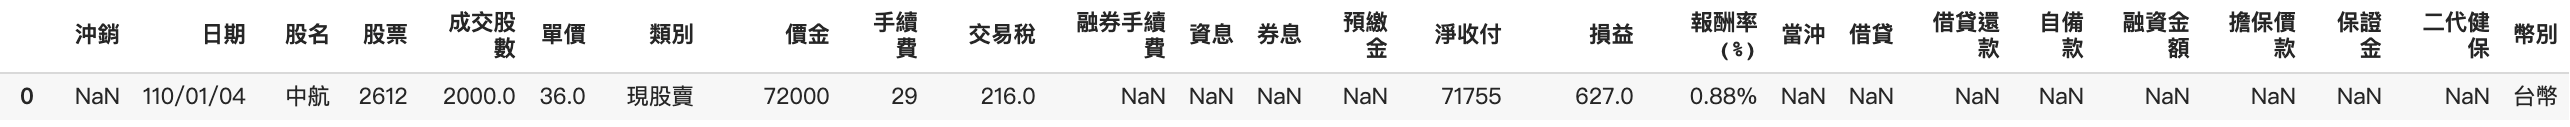

In [ ]:
from pandas import Timestamp
from numpy import nan

demo_data={'date': {0: Timestamp('2021-01-04 00:00:00'),
  1: Timestamp('2021-01-04 00:00:00'),
  2: Timestamp('2021-01-04 00:00:00'),
  3: Timestamp('2021-01-04 00:00:00'),
  4: Timestamp('2021-01-04 00:00:00')},
 'pnl': {0: 627.0, 1: nan, 2: nan, 3: 21900.0, 4: nan},
 'stock_id': {0: '2612 中航',
  1: '5244 弘凱',
  2: '5244 弘凱',
  3: '5244 弘凱',
  4: '3430 奇鈦科'},
 '二代健保': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '交易稅': {0: 216.0, 1: nan, 2: nan, 3: 1188.0, 4: nan},
 '保證金': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '借貸': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '借貸還款': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '價金': {0: 72000, 1: 140500, 2: 157200, 3: 396200, 4: 49400},
 '券息': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '單價': {0: 36.0, 1: 28.1, 2: 26.2, 3: 28.3, 4: 24.7},
 '報酬率(%)': {0: '0.88%', 1: nan, 2: nan, 3: '5.87%', 4: nan},
 '幣別': {0: '台幣', 1: '台幣', 2: '台幣', 3: '台幣', 4: '台幣'},
 '成交股數': {0: 2000.0, 1: 5000.0, 2: 6000.0, 3: 14000.0, 4: 2000.0},
 '手續費': {0: 29, 1: 57, 2: 63, 3: 159, 4: 20},
 '擔保價款': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '沖銷': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '淨收付': {0: 71755, 1: -140557, 2: -157263, 3: 394853, 4: -49420},
 '當沖': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '股名': {0: '中航', 1: '弘凱', 2: '弘凱', 3: '弘凱', 4: '奇鈦科'},
 '股票': {0: '2612', 1: '5244', 2: '5244', 3: '5244', 4: '3430'},
 '自備款': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '融券手續費': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '融資金額': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '資息': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '預繳金': {0: nan, 1: nan, 2: nan, 3: nan, 4: nan},
 '類別': {0: '現股賣', 1: '現股買', 2: '現股買', 3: '現股賣', 4: '現股買'}}

demo_df=pd.DataFrame(demo_data)
demo_df

,date,pnl,stock_id,二代健保,交易稅,保證金,借貸,借貸還款,價金,券息,單價,報酬率(%),幣別,成交股數,手續費,擔保價款,沖銷,淨收付,當沖,股名,股票,自備款,融券手續費,融資金額,資息,預繳金,類別
0,2021-01-04,627.0,2612 中航,NaN,216.0,NaN,NaN,NaN,72000,NaN,36.0,0.88%,台幣,2000.0,29,NaN,NaN,71755,NaN,中航,2612,NaN,NaN,NaN,NaN,NaN,現股賣
1,2021-01-04,NaN,5244 弘凱,NaN,NaN,NaN,NaN,NaN,140500,NaN,28.1,NaN,台幣,5000.0,57,NaN,NaN,-140557,NaN,弘凱,5244,NaN,NaN,NaN,NaN,NaN,現股買
2,2021-01-04,NaN,5244 弘凱,NaN,NaN,NaN,NaN,NaN,157200,NaN,26.2,NaN,台幣,6000.0,63,NaN,NaN,-157263,NaN,弘凱,5244,NaN,NaN,NaN,NaN,NaN,現股買
3,2021-01-04,21900.0,5244 弘凱,NaN,1188.0,NaN,NaN,NaN,396200,NaN,28.3,5.87%,台幣,14000.0,159,NaN,NaN,394853,NaN,弘凱,5244,NaN,NaN,NaN,NaN,NaN,現股賣
4,2021-01-04,NaN,3430 奇鈦科,NaN,NaN,NaN,NaN,NaN,49400,NaN,24.7,NaN,台幣,2000.0,20,NaN,NaN,-49420,NaN,奇鈦科,3430,NaN,NaN,NaN,NaN,NaN,現股買


## Plot

In [ ]:
# 每家券商對帳單格式不同，於process_data()修改欄位，自行複寫function,demo使用新光證券富貴角7號下載的對帳單
# 欄位修改:'日期':'date','損益':'pnl',日期改西元年datetime格式，stock_id換成股票代碼加中文名稱
def process_data(path='drive/MyDrive/sk88/2021對帳.csv'):
    df = pd.read_csv(path)
    df = df.rename(columns={'日期': 'date', '損益': 'pnl'})
    df = df[df['date'] != '總計：']
    df['date'] = df['date'].apply(
        lambda s: datetime.strptime(str(int(s[:s.index('/')]) + 1911) + s[s.index('/'):], "%Y/%m/%d"))
    df['stock_id'] = df['股票'] + ' ' + df['股名']
    return df

# plot
class RealizedProfitLoss:
    def __init__(self,df):
        self.dataframe=df

    def plot(self,start_date=None, end_date=None):
        # 日期控制
        df=self.dataframe
        if start_date:
            df = df[df['date'] >= start_date]
        if end_date:
            df = df[df['date'] <= end_date]

        # 依照stock_id 分group計算每個標的的損益
        date_group = df.groupby(['date'])[['pnl']].sum()
        df = df.groupby(['stock_id'])[['pnl']].sum()
        df = df.reset_index()
        df = df.sort_values(['pnl'])
        # 分類賺賠
        df['category'] = ['profit' if i > 0 else 'loss' for i in df['pnl'].values]
        df['pnl_absolute_value'] = abs(df['pnl'])

        # 製作Sunburst賺賠合併太陽圖所需資料
        df_category = df.groupby(['category'])[['pnl_absolute_value']].sum()
        df_category = df_category.reset_index()
        df_category = df_category.rename(columns={'category': 'stock_id'})
        df_category['category'] = 'total'

        df_total = pd.DataFrame(
            {'stock_id': 'total', 'pnl_absolute_value': df['pnl_absolute_value'].sum(), 'category': ''},
            index=[0])
        df_all = pd.concat([df, df_category, df_total])

        labels = df['stock_id']

        # Create subplots: use 'domain' type for Pie subplot
        fig = make_subplots(rows=4,
                            cols=3,
                            specs=[[{'type': 'domain', "rowspan": 2}, {'type': 'domain', "rowspan": 2},{'type': 'domain', "rowspan": 2}],
                                   [None, None, None],
                                   [{'type': 'xy', "colspan": 3, "secondary_y": True}, None, None],
                                   [{'type': 'xy', "colspan": 3}, None, None]],
                            horizontal_spacing=0.03,
                            vertical_spacing=0.08,
                            subplot_titles=('Profit Pie: ' + str(df[df['pnl'] > 0]['pnl'].sum()),
                                            'Loss Pie: ' + str(df[df['pnl'] < 0]['pnl'].sum()),
                                            'Profit Loss Sunburst: '+str(df['pnl'].sum()),
                                            'Profit Loss Bar By Date',
                                            'Profit Loss Bar By Target',
                                            )

                            )
        # 獲利donut圖
        fig.add_trace(go.Pie(labels=labels, values=df['pnl'], name="profit", hole=.3, textposition='inside',
                            textinfo='percent+label'), row=1, col=1)
        # 虧損donut圖
        fig.add_trace(go.Pie(labels=labels, values=df[df['pnl'] < 0]['pnl'] * -1, name="loss", hole=.3,
                            textposition='inside', textinfo='percent+label'), row=1, col=2)
        # 賺賠合併太陽圖
        fig.add_trace(go.Sunburst(
            labels=df_all.stock_id,
            parents=df_all.category,
            values=df_all.pnl_absolute_value,
            branchvalues='total',
            marker=dict(
                colors=df_all.pnl_absolute_value.apply(lambda s: math.log(s + 0.1)),
                colorscale='earth'),
            textinfo='label+percent entry',
        ), row=1, col=3)

        # 每日已實現損益變化
        fig.add_trace(go.Bar(x=date_group.index, y=date_group['pnl'], name="date", marker_color="#636EFA"), row=3, col=1)
        fig.add_trace(
            go.Scatter(x=date_group.index, y=date_group['pnl'].cumsum(), name="cumsum_realized_pnl",
                      marker_color="#FFA15A"),
            secondary_y=True,row=3, col=1)

        # 標的損益變化
        fig.add_trace(go.Bar(x=df['stock_id'], y=df['pnl'], name="stock_id", marker_color="#636EFA"), row=4, col=1)

        # 修正Y軸標籤
        fig['layout']['yaxis']['title'] = '$NTD'
        fig['layout']['yaxis2']['showgrid']=False
        fig['layout']['yaxis2']['title'] = '$NTD(cumsum)'
        fig['layout']['yaxis3']['title'] = '$NTD'

        # 主圖格式設定標題，長寬
        fig.update_layout(
            title={
                'text': f"Realized Profit Loss Statistic ({start_date}~{end_date})",
                'x': 0.49,
                'y': 0.99,
                'xanchor': 'center',
                'yanchor': 'top'},
            width=1200,
            height=1000)
        return fig


    def run_dash(self):
        # Build App
        app = JupyterDash(__name__)
        app.layout = html.Div([
            html.H1("Realized Profit Loss JupyterDash"),
            html.P("date_range:"),
            dcc.DatePickerRange(
                id='my-date-picker-range',
                min_date_allowed=date(1990, 1, 1),
                max_date_allowed=date(2100, 12, 31),
                initial_visible_month=date(2021, 1, 1),
                start_date=date(2021, 1, 1),
                end_date=date(2021, 12, 31)
            ),
            dcc.Graph(id="graph")
        ])

        @app.callback(
            Output("graph", "figure"),
            [Input('my-date-picker-range', 'start_date'),
             Input('my-date-picker-range', 'end_date')])

        def update_output(start_date, end_date):
            return self.plot(start_date, end_date)

        # Run app and display result inline in the notebook
        app.run_server(mode='inline')


# df=process_data()
# RealizedProfitLoss(df).plot(df,start_date='2021-01-01', end_date='2021-01-31')


# Run Dash

example plot:

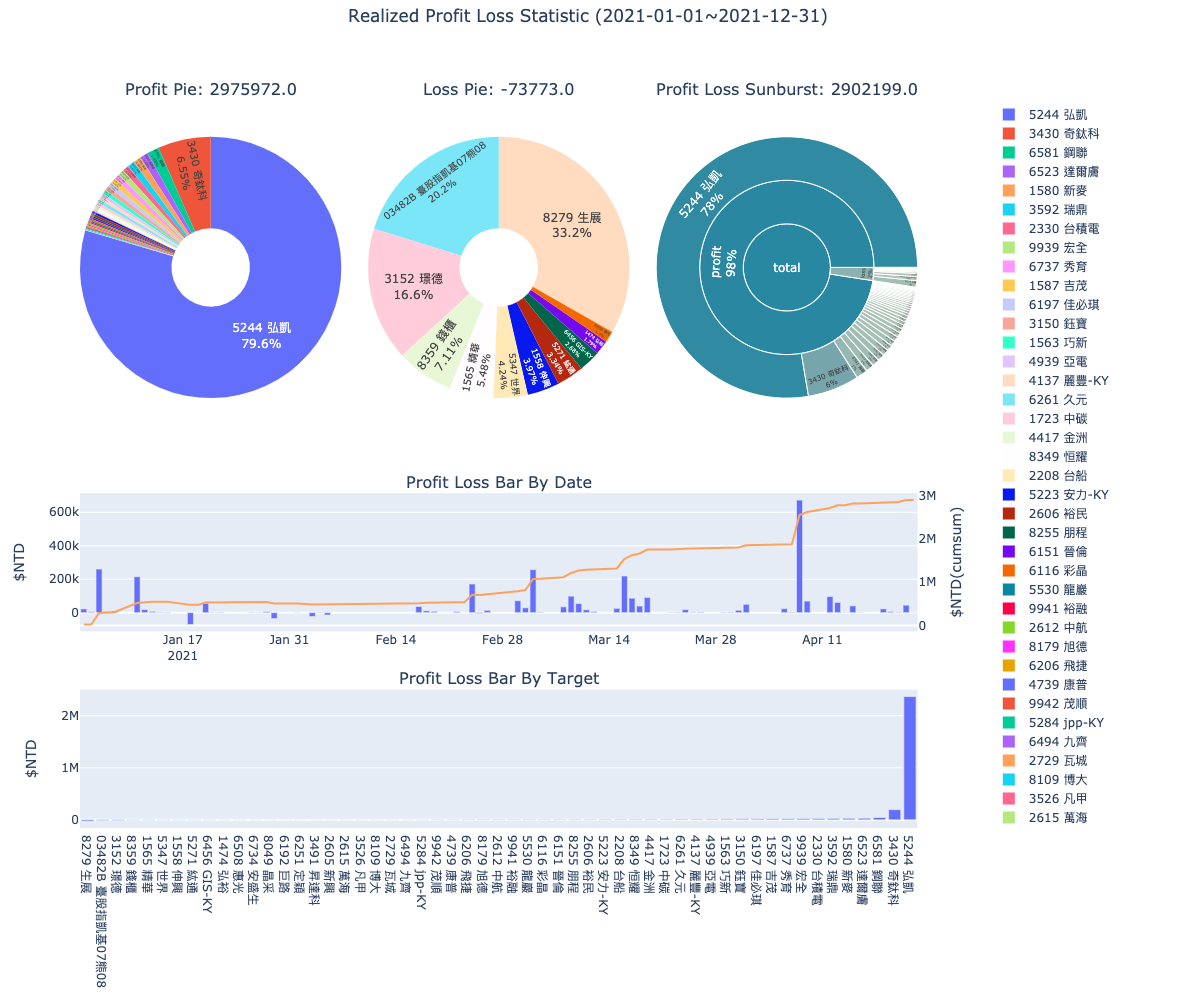

In [ ]:
df=process_data()
RealizedProfitLoss(df).run_dash()

<IPython.core.display.Javascript object>